**Import des données**

In [89]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
#from lightgbm import LGBMRegressor

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

df = pd.read_parquet('../data/parquet/full_2020.csv.parquet', engine='pyarrow')

**Optimisation**

In [90]:
# Liste des colonnes à supprimer (remplissage < 10%)
cols_to_drop_1 = [
    'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle',
    'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
    'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
    'lot5_numero', 'lot5_surface_carrez'
]
# Liste des colonnes avec infos inutiles
cols_to_drop_2 = [
    'id_mutation', 'numero_disposition', 'adresse_numero', 'adresse_suffixe',
    'adresse_nom_voie', 'adresse_code_voie', 'nom_commune', 'id_parcelle',
    'numero_volume', 'code_nature_culture', 'nature_culture','code_nature_culture_speciale'
]
df.drop(columns=cols_to_drop_1, inplace=True)
# Vérification des colonnes restantes
print(f"Shape after dropping columns: {df.shape}")

def optimize_dataframe(df, parse_dates=None, category_thresh=0.05, verbose=True):
    """
    Optimise les types d'un DataFrame pour réduire l'utilisation mémoire :
    - convertit les objets en catégories si nombre de modalités faible
    - convertit les float64 en float32
    - convertit les int64 en int32
    - convertit les colonnes de dates

    Parameters:
    - df : DataFrame à optimiser
    - parse_dates : liste de colonnes à parser comme dates
    - category_thresh : seuil max de ratio modalité/nb lignes pour transformer en 'category'
    - verbose : affiche la mémoire gagnée

    Returns:
    - df optimisé
    """

    initial_memory = df.memory_usage(deep=True).sum() / 1024**2

    # Dates
    if parse_dates:
        for col in parse_dates:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Float → float32
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = df[col].astype('float32')

    # Int → int32
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        if df[col].isnull().any():
            df[col] = df[col].astype('Int32')
        else:
            df[col] = df[col].astype('int32')

    # Object → category si peu de modalités
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique(dropna=False) / len(df) <= category_thresh:
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        print(f"💾 Mémoire utilisée : {initial_memory:.2f} Mo → {final_memory:.2f} Mo ({100 * (1 - final_memory/initial_memory):.1f}% gagné)")

    return df

# Application test sur ech_annonces_ventes_68.csv
optimized_df1 = optimize_dataframe(df, parse_dates=['date_mutation'], verbose=True)
optimized_df1.info()
optimized_df1.head()


Shape after dropping columns: (3522416, 27)
💾 Mémoire utilisée : 2855.43 Mo → 862.50 Mo (69.8% gagné)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522416 entries, 0 to 3522415
Data columns (total 27 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id_mutation                   object        
 1   date_mutation                 datetime64[ns]
 2   numero_disposition            int32         
 3   nature_mutation               category      
 4   valeur_fonciere               float32       
 5   adresse_numero                float32       
 6   adresse_suffixe               category      
 7   adresse_nom_voie              object        
 8   adresse_code_voie             category      
 9   code_postal                   float32       
 10  code_commune                  category      
 11  nom_commune                   category      
 12  code_departement              category      
 13  id_parcelle                   

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,numero_volume,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-01-07,1,Vente,8000.0,NaN,NaN,FORTUNAT,B063,1250.0,01072,Ceyzériat,01,01072000AK0216,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1061.0,5.323532,46.171940
1,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000B0004,NaN,0,NaN,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,85.0,4.893454,46.251858
2,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,BOIS DU CHAMP RION,B006,1290.0,01203,Laiz,01,012030000B0173,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1115.0,4.900210,46.235275
3,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,EN COROBERT,B025,1290.0,01203,Laiz,01,012030000B0477,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1940.0,4.882112,46.246555
4,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000C0068,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1148.0,4.894481,46.251842


**Split**

In [91]:
# Vérification si le DataFrame est vide
if optimized_df1.empty:
    raise ValueError("Le DataFrame 'optimized_df1' est vide après suppression des valeurs manquantes.")

# Calcul de la fréquence des communes
commune_freq = optimized_df1['nom_commune'].value_counts()
optimized_df1['commune_freq'] = optimized_df1['nom_commune'].map(commune_freq)

# Création de la colonne 'coordonnees'
optimized_df1['coordonnees'] = list(zip(optimized_df1['latitude'], optimized_df1['longitude']))

# Colonnes choisies
colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]

# Vérification des colonnes manquantes
colonnes_manquantes = [col for col in colonnes_choisies if col not in optimized_df1.columns]
if colonnes_manquantes:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans 'optimized_df1' : {colonnes_manquantes}")

# Création du DataFrame final
dfRFR = optimized_df1[colonnes_choisies].copy()
# Suppression des valeurs manquantes
dfRFR = dfRFR.dropna()
# Vérification si le DataFrame est vide
if dfRFR.empty:
    raise ValueError("Le DataFrame 'dfRFR' est vide après sélection des colonnes.")

# Définir X (features) et y (target)
X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']

# Vérification si X ou y sont vides
if X.empty or y.empty:
    raise ValueError("Les données pour 'X' ou 'y' sont vides. Vérifiez le contenu de 'dfRFR'.")

# Ajuster test_size si nécessaire
test_size = 0.2
if len(dfRFR) < 5:
    test_size = 1 / len(dfRFR)

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("Split effectué avec succès !")
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Split effectué avec succès !
Taille de l'ensemble d'entraînement : 690602
Taille de l'ensemble de test : 172651


**One Hot Encoding**

In [92]:
# conversion de type
dfRFR['code_type_local'] = dfRFR['code_type_local'].fillna(0).astype(int)

# code_type_local
dfRFR = pd.get_dummies(dfRFR, columns=['code_type_local'], prefix='code_type_local')


# Vérification de l'existence de la colonne 'code_type_local'
if 'code_type_local' in dfRFR.columns:
    # Remplir les valeurs manquantes avec 0 et convertir en entier
    dfRFR['code_type_local'] = dfRFR['code_type_local'].fillna(0).astype(int)
    
    # Transformation en variables indicatrices (one-hot encoding)
    dfRFR = pd.get_dummies(dfRFR, columns=['code_type_local'], prefix='code_type_local')
else:
    raise KeyError("La colonne 'code_type_local' n'existe pas dans le DataFrame.")

KeyError: "La colonne 'code_type_local' n'existe pas dans le DataFrame."

**Post DropNa**

In [ ]:
# Corrélation de Spearman
#spearman_corr = dfRFR.corr(method='spearman', numeric_only=True)

# Extraire les corrélations avec 'valeur_fonciere' uniquement
#valeur_corr_spearman = spearman_corr['valeur_fonciere'].drop('valeur_fonciere')

# Trier par valeur absolue (décroissant)
#valeur_corr_spearman_sorted = valeur_corr_spearman.reindex(valeur_corr_spearman.abs().sort_values(ascending=False).index)

# Affichage
#print(valeur_corr_spearman_sorted)
dfRFR.head()

,valeur_fonciere,surface_terrain,surface_reelle_bati,nombre_pieces_principales,commune_freq,nombre_lots,code_type_local_1,code_type_local_2,code_type_local_4
11,72000.0,381.0,35.0,2.0,93,0,True,False,False
13,180300.0,525.0,75.0,4.0,1507,0,True,False,False
16,350750.0,1267.0,201.0,7.0,363,0,True,False,False
18,350750.0,1497.0,201.0,7.0,363,0,True,False,False
22,53650.0,195.0,50.0,2.0,93,0,False,True,False


**Premier Test RandomForestRegressor**

RMSE ≈ 2 470 772 €

R² ≈ 0.935

(690602, 6) (172651, 6)
RMSE : 2569145.9906352833
R² : 0.9501699724782149


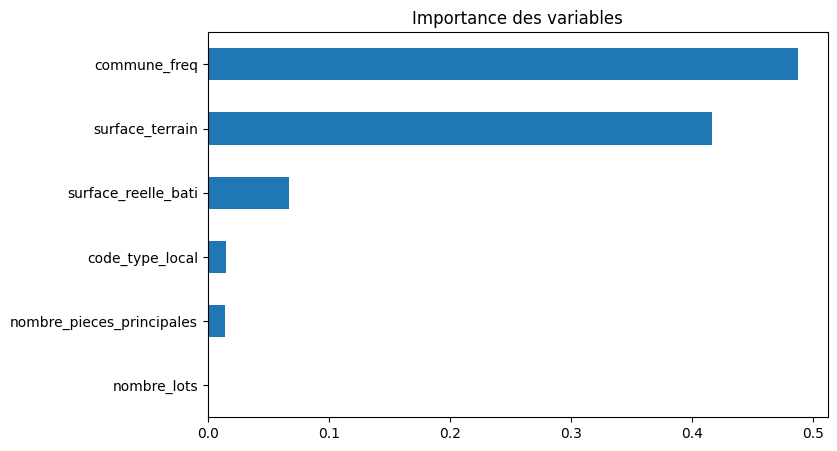

<class 'pandas.core.frame.DataFrame'>
Index: 863253 entries, 11 to 3522414
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   valeur_fonciere            863253 non-null  float32
 1   surface_terrain            863253 non-null  float32
 2   surface_reelle_bati        863253 non-null  float32
 3   nombre_pieces_principales  863253 non-null  float32
 4   commune_freq               863253 non-null  int64  
 5   nombre_lots                863253 non-null  int32  
 6   code_type_local_1          863253 non-null  bool   
 7   code_type_local_2          863253 non-null  bool   
 8   code_type_local_4          863253 non-null  bool   
dtypes: bool(3), float32(4), int32(1), int64(1)
memory usage: 32.1 MB


In [ ]:
print(X_train.shape, X_test.shape)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables")
plt.show()

dfRFR.info()

**Fonction logarithmique**

RMSE : 3115740.937183387

R² : 0.8963601575459054

In [ ]:
dfRFRLog = dfRFR[colonnes_choisies].copy()

# Définir X (features) et y (target)
X = dfRFRLog.drop(columns='valeur_fonciere')
y = dfRFRLog['valeur_fonciere']

# Transformation log de la cible
y_log = np.log1p(y)  # log1p gère les y=0 éventuels

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

# Modèle RandomForest
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Prédictions dans l'espace log
y_pred_log = model.predict(X_test)

# Retour à l'échelle des prix réels
y_pred = np.expm1(y_pred_log)     # inverse de log1p
y_test_real = np.expm1(y_test)    # idem pour la vraie valeur

# Évaluation
rmse = root_mean_squared_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

print("RMSE :", rmse)
print("R² :", r2)

# Importance des variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables (RandomForest)")
plt.show()

KeyError: "['code_type_local'] not in index"

**Suppression des valeurs aberrantes**

RMSE : 92186.59412765941

R² : 0.366582826222593

(600081, 7) (150021, 7)
RMSE : 103845.17217765008
R² : 0.3934249456937223


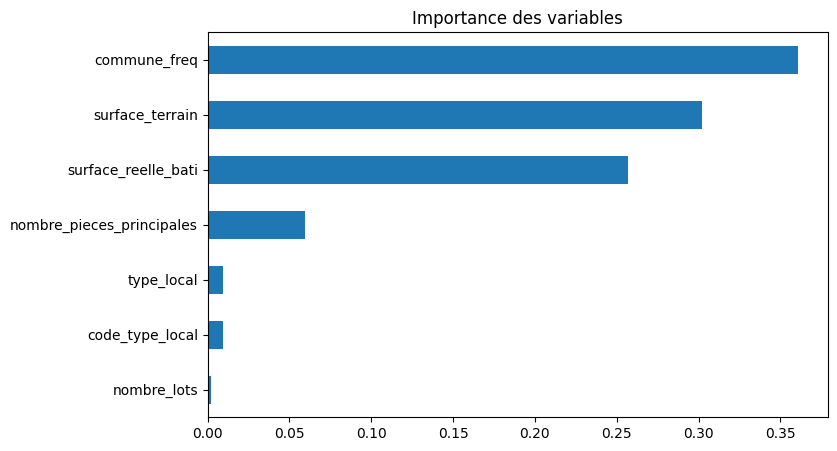

In [ ]:
# Calcul des quartiles pour la colonne valeur_fonciere
Q1 = dfRFR['valeur_fonciere'].quantile(0.25)
Q3 = dfRFR['valeur_fonciere'].quantile(0.75)
IQR = Q3 - Q1

# Suppression des valeurs aberrantes uniquement selon valeur_fonciere
dfRFR = dfRFR[
    (dfRFR['valeur_fonciere'] >= Q1 - 1.5 * IQR) &
    (dfRFR['valeur_fonciere'] <= Q3 + 1.5 * IQR)
]

dfRFR = dfRFR[colonnes_choisies].copy()


# Définir X (features) et y (target)
X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables")
plt.show()


**Test LightGBM**

RMSE : 110068.43252065268

R² : 0.3185445167670684

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 600081, number of used features: 7
[LightGBM] [Info] Start training from score 11.964992
RMSE : 103845.17225817383
R² : 0.39342494116017046


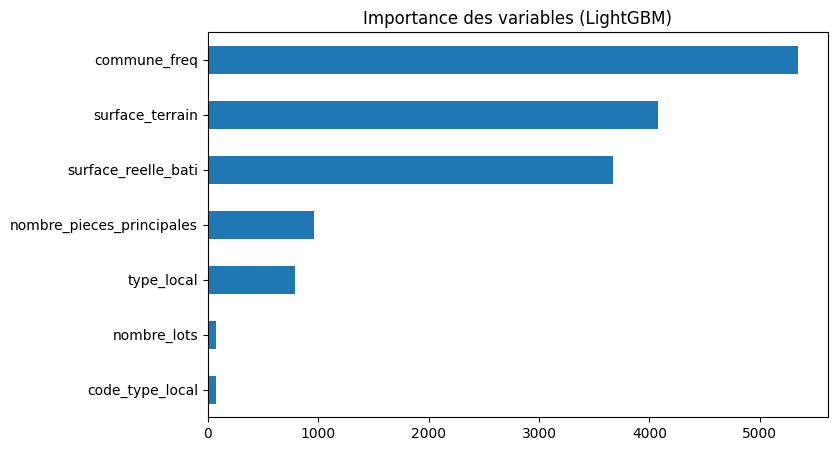

In [ ]:
#
#
#colonnes_choisies = [
#    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
#    'type_local', 'code_type_local', 'nombre_pieces_principales',
#    'commune_freq', 'nombre_lots'
#]
#dfRFR = optimized_df1[colonnes_choisies].copy()
#
#X = dfRFR.drop(columns='valeur_fonciere')
#y = dfRFR['valeur_fonciere']
#
#
#y_log = np.log1p(y)
#
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y_log, test_size=0.2, random_state=42
#)
#
#
#rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#rf.fit(X_train, y_train)
#
#y_pred_rf_log = rf.predict(X_test)
#y_pred_rf = np.expm1(y_pred_rf_log)
#y_test_real = np.expm1(y_test)
#
#
#lgbm = LGBMRegressor(
#    n_estimators=500,
#    learning_rate=0.05,
#    max_depth=-1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42,
#    n_jobs=-1
#)
#lgbm.fit(X_train, y_train)
#
#y_pred_lgbm_log = lgbm.predict(X_test)
#y_pred_lgbm = np.expm1(y_pred_lgbm_log)
#
#
#rmse = root_mean_squared_error(y_test_real, y_pred)
#r2 = r2_score(y_test_real, y_pred)
#
#print("RMSE :", rmse)
#print("R² :", r2)
#
#
#importances = pd.Series(lgbm.feature_importances_, index=X.columns)
#importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
#plt.title("Importance des variables (LightGBM)")
#plt.show()

**Tentative avec NN Tensorflow / Kera**

RMSE : 9509432.0

R² : 0.03458684682846069

In [ ]:
#colonnes_choisies = [
#    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
#    'type_local', 'code_type_local', 'nombre_pieces_principales',
#    'commune_freq', 'nombre_lots'
#]
#dfRFR = optimized_df1[colonnes_choisies].copy()
#
#
#X = dfRFR.drop(columns=["valeur_fonciere"])
#y = dfRFR["valeur_fonciere"]
#
## Normalisation (les NN aiment ça)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
## Découpage train/test
#X_train, X_test, y_train, y_test = train_test_split(
#    X_scaled, y, test_size=0.2, random_state=42
#)
#
## Modèle de réseau de neurones
#model = keras.Sequential([
#    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
#    layers.Dense(32, activation="relu"),
#    layers.Dense(1)  # sortie = valeur fonciere
#])
#
#model.compile(optimizer="adam", loss="mse", metrics=["mae"])
#
## Entraînement
#history = model.fit(X_train, y_train, 
#                    validation_split=0.2,
#                    epochs=50, batch_size=256)
#
#
#
#y_pred = model.predict(X_test)
#rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
#r2 = r2_score(y_test, y_pred)
#
#mse, mae = model.evaluate(X_test, y_test, verbose=0)
#
#print(f"Erreur quadratique moyenne (MSE): {mse:.2f}")
#print(f"Erreur absolue moyenne (MAE): {mae:.2f}")
#
#print("RMSE :", rmse)
#print("R² :", r2)

Epoch 1/50


c:\Users\shipu\Documents\GitHub\compagnon-immobilier\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 2s 652us/step - loss: 91570028150784.0000 - mae: 1358562.2500 - val_loss: 90802512461824.0000 - val_mae: 1353290.8750
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 90394960330752.0000 - mae: 1344766.0000 - val_loss: 89008348594176.0000 - val_mae: 1413869.7500
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 88643855187968.0000 - mae: 1480864.8750 - val_loss: 87504069853184.0000 - val_mae: 1592465.1250
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 87670063628288.0000 - mae: 1642551.0000 - val_loss: 86915072131072.0000 - val_mae: 1720321.2500
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - loss: 87293004087296.0000 - mae: 1733238.5000 - val_loss: 86643365117952.0000 - val_mae: 1786265.8750
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - loss: 87091685883904.0000 - mae: 1784660.1250 - val_loss: 86470845005824.0000 - val_mae: 1823226.6250
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/